#### 주요 구성 요소
- 상태 관리: TypedDict를 사용하여 각 고객 상호작용의 상태를 정의하고 관리.
- 쿼리 분류: 고객 쿼리를 기술, 청구 또는 일반 범주로 분류.
- 감정 분석: 고객 쿼리의 감정적 톤을 파악.
- 응답 생성: 쿼리 범주 및 감정을 기반으로 적절한 응답을 생성.
- 에스컬레이션 메커니즘: 부정적인 감정을 가진 쿼리를 자동으로 상담원에게 에스컬레이션.
- 워크플로 그래프: LangGraph를 활용하여 유연하고 확장 가능한 워크플로를 생성.

#### 메서드 세부 정보

- 초기화: 환경을 설정하고 필요한 라이브러리를 가져옵니다.
- 상태 정의: 쿼리 정보, 카테고리, 감정 및 응답을 보관하는 구조를 생성합니다.
- 노드 함수: 분류, 감정 분석 및 응답 생성을 위한 별도의 함수를 구현합니다.
- 그래프 생성: StateGraph를 사용하여 워크플로를 정의하고, 지원 프로세스를 나타내는 노드와 에지를 추가합니다.
- 조건부 라우팅: 카테고리 및 감정에 따라 쿼리를 라우팅하는 로직을 구현합니다.
- 워크플로 컴파일: 그래프를 실행 가능한 애플리케이션으로 컴파일합니다.
- 실행: 워크플로를 통해 고객 쿼리를 처리하고 결과를 검색합니다.

In [ ]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os

# Load environment variables and set OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

In [2]:
class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

In [3]:
def categorize(state: State) -> State:
    """Categorize the customer query into Technical, Billing, or General."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query}"
    )
    chain = prompt | ChatOpenAI(model="gpt-4.1-2025-04-14", temperature=0.0)
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}

def analyze_sentiment(state: State) -> State:
    """Analyze the sentiment of the customer query as Positive, Neutral, or Negative."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | ChatOpenAI(model="gpt-4.1-2025-04-14", temperature=0.0)
    sentiment = chain.invoke({"query": state["query"]}).content
    return {"sentiment": sentiment}

def handle_technical(state: State) -> State:
    """Provide a technical support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(model="gpt-4.1-2025-04-14", temperature=0.0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_billing(state: State) -> State:
    """Provide a billing support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(model="gpt-4.1-2025-04-14", temperature=0.0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_general(state: State) -> State:
    """Provide a general support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(model="gpt-4.1-2025-04-14", temperature=0.0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def escalate(state: State) -> State:
    """Escalate the query to a human agent due to negative sentiment."""
    return {"response": "This query has been escalated to a human agent due to its negative sentiment."}

def route_query(state: State) -> str:
    """Route the query based on its sentiment and category."""
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Billing":
        return "handle_billing"
    else:
        return "handle_general"

In [4]:
# Create the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

# Add edges
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

# Set entry point
workflow.set_entry_point("categorize")

# Compile the graph
app = workflow.compile()

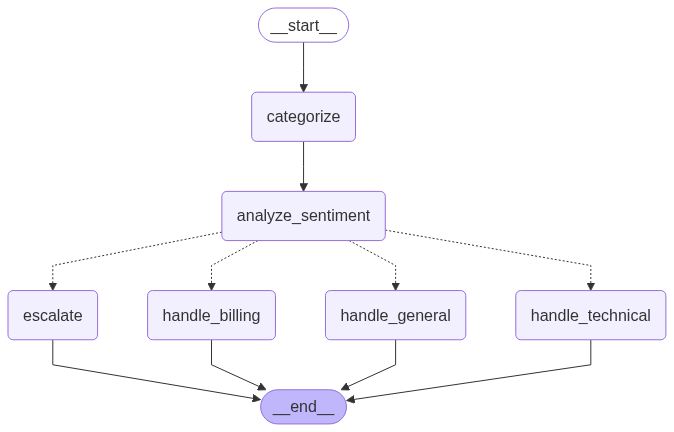

In [5]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [6]:
def run_customer_support(query: str) -> Dict[str, str]:
    """Process a customer query through the LangGraph workflow.
    
    Args:
        query (str): The customer's query
        
    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    results = app.invoke({"query": query})
    return {
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"]
    }

In [7]:
# escalate

query = "My internet connection keeps dropping. Can you help?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: My internet connection keeps dropping. Can you help?
Category: Category: Technical
Sentiment: Negative
Response: This query has been escalated to a human agent due to its negative sentiment.




In [8]:
# handle_technical

query = "I need help talking to chatGPT"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: I need help talking to chatGPT
Category: Category: General
Sentiment: Neutral
Response: Of course! I’m here to help you get started with ChatGPT.

To talk to ChatGPT, just type your question or message in the chat box and send it. You can ask about almost anything—whether you need information, help with writing, explanations, or just want to have a conversation. Try to be as clear and specific as possible so I can give you the best answer.

If you’re not sure how to phrase your question, you can start with something simple like, “Can you help me with…” or “What do you know about…”

Let me know what you’d like to talk about or if you have a specific question!




In [9]:
# handle_billing

query = "where can i find my receipt?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: where can i find my receipt?
Category: Category: Billing
Sentiment: Neutral
Response: Thank you for reaching out! You can usually find your receipt in the confirmation email sent to you after your purchase. Please check your inbox (and spam or junk folder, just in case) for an email from us. If you made your purchase through your account on our website or app, you may also be able to view and download your receipt by logging in and checking your order history or account settings. If you’re still unable to locate your receipt, please let us know your order details and we’ll be happy to assist further!




In [10]:
# handle_general

query = "What are your business hours?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")

Query: What are your business hours?
Category: Category: General
Sentiment: Neutral
Response: Thank you for reaching out! Our business hours are [insert your business hours here, e.g., Monday to Friday, 9:00 AM to 5:00 PM]. If you have any other questions or need assistance outside of these hours, please feel free to leave a message, and we will get back to you as soon as possible.
